In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import Variable
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import functools

In [3]:
n_classes = 43

def rand_tensor(shape):
    return Variable(tf.truncated_normal(shape, stddev=0.1))

def zero_tensor(shape):
    return Variable(tf.zeros(shape))

def conv2d(x, w, b, stride=1):
    """Convolution2D op with filter w
    """
    x = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return x

def avgpool2d(x, k=2):
    """Average pooli            sess.run(tf.initialize_all_variables())ng op with kernel size = k and same stride
    """
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1], padding="SAME")

def maxpool2d(x, k=2):
    """Maximum pooling op with kernel size = k and same stride
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1], padding="SAME")

def fully_connected(x, w, b):
    x = tf.add(tf.matmul(x, w), b)
    return x

def relu(x):
    return tf.nn.relu(x)

def flatten(x):
    batch_shape = tf.pack([-1, tf.reduce_prod(tf.shape(x)[1:])])
    x = tf.reshape(x, batch_shape)
    return x

def dropout(x, p):
    return tf.nn.dropout(x, p)

# construct CNN based on layers and their parameters
def conv_net(x, layers):
    """Build a convolutional network out of input `x` and parameter variables
    """
    layer_constructors = {
        "conv": conv2d
        , "avgpool": avgpool2d
        , "maxpool": maxpool2d
        , "fc": fully_connected
        , "relu": relu
        , "flatten": flatten
        , "dropout": dropout
    }
    for name, param in layers:
        param.update({"x": x})
        x = layer_constructors[name](**param)
    return x

n_colors = 1
keep_prob = tf.placeholder(tf.float32)
batch_images = tf.placeholder(tf.float32, [None, 32, 32, n_colors])
batch_labels = tf.placeholder(tf.float32, [None, n_classes])

# layer and parameters
layers = [ 
    # conv_pool block 1
     ("conv", {"w": rand_tensor([3, 3, n_colors, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("dropout", {"p": keep_prob})
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 2
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 3
    , ("conv", {"w": rand_tensor([3, 3, 64, 128]),
                "b": zero_tensor([128])})
    , ("relu", {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # flatten
    , ("flatten", {})
    
    # fully connected block 1
    ## after 2 pooling, the image size will become
    ## 32 / 2 / 2 / 2 = 4
    , ("fc", {"w": rand_tensor([4 * 4 * 128, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # fully connected block 2
    , ("fc", {"w": rand_tensor([1024, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # output layer
    , ("fc", {"w": rand_tensor([1024, n_classes]),
              "b": zero_tensor([n_classes])})
]

scores = conv_net(batch_images, layers)
probs = tf.nn.softmax(scores)

In [4]:
def load_label_desc(label_file):
    lines = open(label_file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs


def onehot_encode(labels, nb_classes=None):
    nb_classes = nb_classes or (np.max(labels) + 1)
    y = np.zeros((labels.shape[0], nb_classes))
    y[np.arange(labels.shape[0]), labels] = 1.
    return y.astype(np.float32)

def preprocess_grayscale(images):
    #return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

def preprocess_yuv(images):
    #return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV) for img in images])

def preprocess_normalize(images):
    return images / 255.

def preprocess_expanddim(images):
    return np.expand_dims(images, axis=3)

def preprocess_tofloat32(images):
    return images.astype(np.float32)

def compose(functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions[::-1])

preprocess_steps = [preprocess_grayscale, preprocess_normalize, 
                   preprocess_expanddim, preprocess_tofloat32]
p = compose(preprocess_steps)


class CNNSignClassifier(object):
    def __init__(self, model_path, signames_path):
        self.model_path = model_path
        self.signames = load_label_desc(signames_path)
    def preprocess(self, img):
        img = cv2.resize(img, (32, 32))
        x = p(np.array([img]))
        return x
    def predict(self, img):
        import pandas as pd
        x = self.preprocess(img)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, self.model_path)
            prob_vals = sess.run(probs, feed_dict={batch_images: x, keep_prob: 1.})[0]
        
        return pd.DataFrame(prob_vals, columns=["probs"],
            index=[self.signames[i] for i in range(prob_vals.shape[0])])

In [5]:
n_colors = 1
keep_prob = tf.placeholder(tf.float32)
batch_images = tf.placeholder(tf.float32, [None, 32, 32, n_colors])
batch_labels = tf.placeholder(tf.float32, [None, n_classes])

# layer and parameters
layers = [ 
    # conv_pool block 1
     ("conv", {"w": rand_tensor([3, 3, n_colors, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("dropout", {"p": keep_prob})
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 2
    , ("conv", {"w": rand_tensor([3, 3, 64, 64]), 
               "b": zero_tensor([64])})
    , ('relu', {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # conv_pool block 3
    , ("conv", {"w": rand_tensor([3, 3, 64, 128]),
                "b": zero_tensor([128])})
    , ("relu", {})
    , ("avgpool", {})
    , ("dropout", {"p": keep_prob})
    
    # flatten
    , ("flatten", {})
    
    # fully connected block 1
    ## after 2 pooling, the image size will become
    ## 32 / 2 / 2 / 2 = 4
    , ("fc", {"w": rand_tensor([4 * 4 * 128, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # fully connected block 2
    , ("fc", {"w": rand_tensor([1024, 1024]),
              "b": zero_tensor([1024])})
    , ("relu", {})
    
    # output layer
    , ("fc", {"w": rand_tensor([1024, n_classes]),
              "b": zero_tensor([n_classes])})
]

scores = conv_net(batch_images, layers)
probs = tf.nn.softmax(scores)

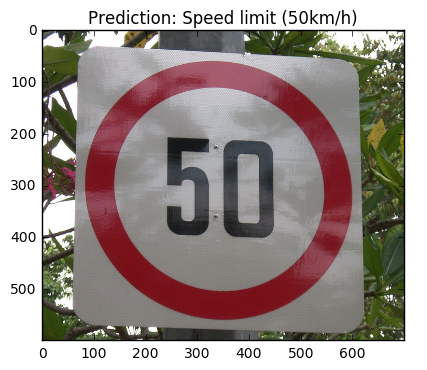

In [6]:
img = cv2.imread("test_images/limit50.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

sign_classifier = CNNSignClassifier("models/model.ckpt", "signnames.csv")
label_prediction = sign_classifier.predict(img).idxmax()
plt.imshow(img)
plt.title("Prediction: " + label_prediction[0])